<a href="https://colab.research.google.com/github/yequalsmxplusc/project/blob/main/CHT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymoo pyswarm openpyxl

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 6.2 MB/s eta 0:00:00
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=2c6a55a7e6ff41e61c64cefa86dd70b382d26970e24d5add6e8e40e8a7a39f66
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=91f84a539f322bb519944f62cfc44201a3fa7a80743c0f6ad3834d1cd19037c2
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Suc

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pyswarm import pso

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

def load_and_preprocess_data(data_path, test_ratio=0.2, seq_length=10):
    data = pd.read_excel(data_path)
    data = data.sort_values('time')
    data['liquid_frac_rolling'] = data['liquid_frac'].rolling(window=5).mean()
    data = data.dropna()

    split_idx = int(len(data) * (1 - test_ratio))
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]

    def create_sequences(df):
        sequences, targets = [], []
        features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']
        target_col = ['T_battery']
        for i in range(len(df) - seq_length):
            seq = df.iloc[i:i+seq_length]
            sequences.append(seq[features].values)
            targets.append(seq[target_col].iloc[-1].values)
        return np.array(sequences), np.array(targets)

    X_train, y_train = create_sequences(train_data)
    X_test, y_test = create_sequences(test_data)

    def normalize(X_train, X_test, y_train, y_test):
        X_mean, X_std = X_train.mean(axis=(0, 1)), X_train.std(axis=(0, 1))
        y_mean, y_std = y_train.mean(axis=0), y_train.std(axis=0)
        X_train = (X_train - X_mean) / (X_std + 1e-8)
        X_test = (X_test - X_mean) / (X_std + 1e-8)
        y_train = (y_train - y_mean) / (y_std + 1e-8)
        y_test = (y_test - y_mean) / (y_std + 1e-8)
        return X_train, X_test, y_train, y_test, (X_mean, X_std, y_mean, y_std)


    def augment_data(X, y, noise_factor=0.01):
     """Add synthetic noise to training data"""
     X_noisy = X + noise_factor * np.random.randn(*X.shape)
     return np.vstack([X, X_noisy]), np.vstack([y, y])

    X_train, y_train = augment_data(X_train, y_train)
    return normalize(X_train, X_test, y_train, y_test)


# Load and preprocess data for aspect ratio 0.3
X_train, X_test, y_train, y_test, norm_stats = load_and_preprocess_data('/content/0.3.xlsx')

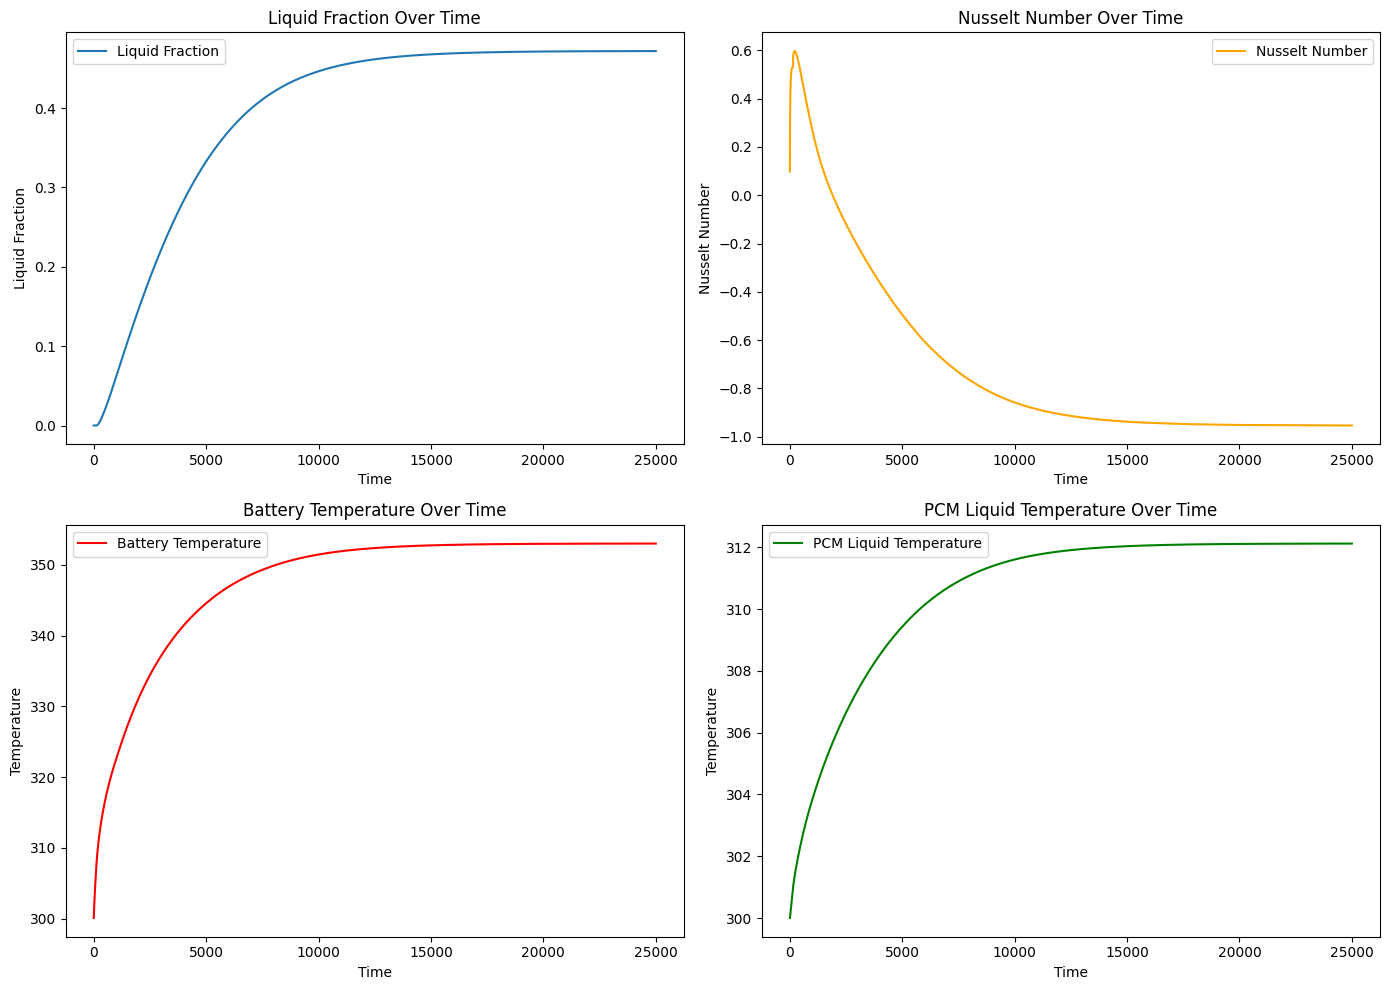

In [3]:
import matplotlib.pyplot as plt

# Load your data from an Excel file
df = pd.read_excel('/content/0.3.xlsx')  # Replace 'your_data_file.xlsx' with the path to your actual data file

# Sort data by time
df = df.sort_values('time')

# Plotting the data
plt.figure(figsize=(14, 10))

# Plot Liquid Fraction
plt.subplot(2, 2, 1)
plt.plot(df['time'], df['liquid_frac'], label='Liquid Fraction')
plt.xlabel('Time')
plt.ylabel('Liquid Fraction')
plt.title('Liquid Fraction Over Time')
plt.legend()

# Plot Nusselt Number
plt.subplot(2, 2, 2)
plt.plot(df['time'], df['Nu'], label='Nusselt Number', color='orange')
plt.xlabel('Time')
plt.ylabel('Nusselt Number')
plt.title('Nusselt Number Over Time')
plt.legend()

# Plot Battery Temperature
plt.subplot(2, 2, 3)
plt.plot(df['time'], df['T_battery'], label='Battery Temperature', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Battery Temperature Over Time')
plt.legend()

# Plot PCM Liquid Temperature
plt.subplot(2, 2, 4)
plt.plot(df['time'], df['T_pcm'], label='PCM Liquid Temperature', color='green')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('PCM Liquid Temperature Over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pyswarm import pso

# Define the LSTM model
class SimplePINN(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(SimplePINN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Predict temperature

    def forward(self, x):
        # Ensure the input tensor has the correct shape
        if x.dim() == 2:
            x = x.unsqueeze(0)  # Add batch dimension if it's missing
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        return self.fc(last_out)

# Load and preprocess data
def load_and_preprocess_data(data_path, test_ratio=0.2, seq_length=10):
    data = pd.read_excel(data_path)
    data = data.sort_values('time')
    data['liquid_frac_rolling'] = data['liquid_frac'].rolling(window=5).mean()
    data = data.dropna()

    split_idx = int(len(data) * (1 - test_ratio))
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]

    def create_sequences(df):
        sequences, targets = [], []
        features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']
        target_col = ['T_battery']
        for i in range(len(df) - seq_length):
            seq = df.iloc[i:i+seq_length]
            sequences.append(seq[features].values)
            targets.append(seq[target_col].iloc[-1].values)
        return np.array(sequences), np.array(targets)

    X_train, y_train = create_sequences(train_data)
    X_test, y_test = create_sequences(test_data)

    def normalize(X_train, X_test, y_train, y_test):
        X_mean, X_std = X_train.mean(axis=(0, 1)), X_train.std(axis=(0, 1))
        y_mean, y_std = y_train.mean(axis=0), y_train.std(axis=0)
        X_train = (X_train - X_mean) / (X_std + 1e-8)
        X_test = (X_test - X_mean) / (X_std + 1e-8)
        y_train = (y_train - y_mean) / (y_std + 1e-8)
        y_test = (y_test - y_mean) / (y_std + 1e-8)
        return X_train, X_test, y_train, y_test, (X_mean, X_std, y_mean, y_std)

    return normalize(X_train, X_test, y_train, y_test)

# Load and preprocess data
X_train, X_test, y_train, y_test, norm_stats = load_and_preprocess_data('/content/0.3.xlsx')

# Define the optimization problem
class BatteryCoolingProblem(Problem):
    def __init__(self, model, X_train, y_train):
        super().__init__(n_var=3, n_obj=2, n_constr=1, xl=np.array([0.1, 1000, 0.1]), xu=np.array([0.9, 2000, 0.9]))
        self.model = model
        self.X_train = X_train
        self.y_train = y_train

    def _evaluate(self, x, out, *args, **kwargs):
        x = x.reshape(-1, 3)
        liquid_frac, Nu, T_pcm = x[:, 0], x[:, 1], x[:, 2]

        temps = 50 - 15*0.3 + 0.5*np.sin(10*0.3) + 0.1*liquid_frac - 0.05*Nu + 0.01*T_pcm
        safety_margins = 5 + 20*0.3 - 2*np.cos(8*0.3) - 0.2*liquid_frac + 0.1*Nu - 0.05*T_pcm
        vortex_constraint = 0.3 - (0.35 + 0.05*np.sin(5*0.3)) + 0.01*liquid_frac - 0.005*Nu + 0.001*T_pcm

        out["F"] = np.column_stack([temps, -safety_margins])
        out["G"] = vortex_constraint

# Initialize the model
model = SimplePINN(input_size=4)

# Example usage of the optimization problem
problem = BatteryCoolingProblem(model, torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
algorithm = NSGA2(pop_size=30, n_offsprings=15, eliminate_duplicates=True)
res = minimize(problem, algorithm, ('n_gen', 75), seed=42, verbose=True)

# Define the objective function for PSO
def objective_function(x):
    return np.sum(x**2)  # Replace with your actual objective function

# Run PSO to get optimized parameters
lb = [0.1, 1000, 0.1]
ub = [0.9, 2000, 0.9]
x_opt, _ = pso(objective_function, lb, ub, swarmsize=20, maxiter=50)

# Example: Modify dataset based on optimization results
optimized_params = np.append(x_opt, 300.0)  # Assuming T_pcm is the fourth parameter
optimized_data = pd.DataFrame({
    'aspect_ratio': optimized_params[0],
    'liquid_frac': optimized_params[1],
    'Nu': optimized_params[2],
    'T_pcm': optimized_params[3],
    'T_battery': model(torch.tensor(optimized_params[:4], dtype=torch.float32).unsqueeze(0)).item()
}, index=[0])

# Save the optimized dataset
optimized_data.to_csv('optimized_data.csv', index=False)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       30 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |       45 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     3 |       60 |      1 |  0.000000E+00 |  0.000000E+00 |  2.3208224393 |         ideal
     4 |       75 |      1 |  0.000000E+00 |  0.000000E+00 |  0.3633220635 |         ideal
     5 |       90 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |      105 |      1 |  0.000000E+00 |  0.000000E+00 |  0.7234067849 |         ideal
     7 |      120 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |      135 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0525466186 |         ideal
     9 |      150 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |      165 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0210259233 |         ideal

In [6]:
import torch
import torch.nn as nn

class EnhancedPINN(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(EnhancedPINN, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
            )

    def forward(self, x):
        # Ensure correct input dimensions [batch, seq_len, features]
        if x.dim() == 2:
            x = x.unsqueeze(0)

        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # Get last timestep output
        last_out = lstm_out[:, -1, :]

        # Fully connected layers
        return self.fc(last_out)

# Initialize model
model = EnhancedPINN(input_size=4)  # 4 input features

# Training parameters
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
epochs = 100
batch_size = 32

# Data preparation
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Training loop
print("Starting training...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Print statistics
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

print("Training completed!")

Starting training...
Epoch [10/100], Loss: 0.0056
Epoch [20/100], Loss: 0.0052
Epoch [30/100], Loss: 0.0049
Epoch [40/100], Loss: 0.0050
Epoch [50/100], Loss: 0.0048
Epoch [60/100], Loss: 0.0045
Epoch [70/100], Loss: 0.0043
Epoch [80/100], Loss: 0.0044
Epoch [90/100], Loss: 0.0045
Epoch [100/100], Loss: 0.0046
Training completed!


In [7]:
def load_data(data_path):
    """Load data file (CSV or Excel) without time-series processing"""
    if data_path.endswith('.csv'):
        return pd.read_csv(data_path, encoding='latin1')
    else:
        return pd.read_excel(data_path, engine='openpyxl')

def load_and_preprocess_data(data_path, test_ratio=0.2, seq_length=10):
    """Handle both time-series and optimization result files"""
    data = load_data(data_path)

    # CASE 1: Time-series data (has 'time' column)
    if 'time' in data.columns:
        data = data.sort_values('time')
        if 'liquid_frac' in data.columns:
            data['liquid_frac_rolling'] = data['liquid_frac'].rolling(window=5).mean()
        data = data.dropna()

        # Train-test split
        split_idx = int(len(data) * (1 - test_ratio))
        train_data = data.iloc[:split_idx]
        test_data = data.iloc[split_idx:]

        # Create sequences
        def create_sequences(df):
            sequences, targets = [], []
            features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']
            target_col = ['T_battery']
            for i in range(len(df) - seq_length):
                seq = df.iloc[i:i+seq_length]
                sequences.append(seq[features].values)
                targets.append(seq[target_col].iloc[-1].values)
            return np.array(sequences), np.array(targets)

        X_train, y_train = create_sequences(train_data)
        X_test, y_test = create_sequences(test_data)

    # CASE 2: Optimization results (single/multiple rows)
    else:
        features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']
        target_col = ['T_battery']

        # Convert single row to sequence format
        if len(data) == 1:
            X_train = np.array([data[features].values] * seq_length).reshape(1, seq_length, -1)
            y_train = data[target_col].values
            X_test, y_test = X_train.copy(), y_train.copy()
        else:
            X_train = np.stack([data[features].values] * seq_length, axis=1)
            y_train = data[target_col].values
            X_test, y_test = X_train.copy(), y_train.copy()

    # Normalization
    def normalize(X_train, X_test, y_train, y_test):
        X_mean = X_train.mean(axis=(0, 1)) if X_train.ndim == 3 else X_train.mean()
        X_std = X_train.std(axis=(0, 1)) if X_train.ndim == 3 else X_train.std()
        y_mean, y_std = y_train.mean(axis=0), y_train.std(axis=0)

        X_train = (X_train - X_mean) / (X_std + 1e-8)
        X_test = (X_test - X_mean) / (X_std + 1e-8)
        y_train = (y_train - y_mean) / (y_std + 1e-8)
        y_test = (y_test - y_mean) / (y_std + 1e-8)

        return X_train, X_test, y_train, y_test, (X_mean, X_std, y_mean, y_std)

    return normalize(X_train, X_test, y_train, y_test)

# Usage
try:
    # For time-series data
    X_train_04, X_test_04, y_train_04, y_test_04, _ = load_and_preprocess_data('/content/0.4.xlsx')

    # For optimization results
    X_train_opt, X_test_opt, y_train_opt, y_test_opt, _ = load_and_preprocess_data('/content/optimized_data.csv')

except Exception as e:
    print(f"Error: {str(e)}")

In [8]:
def load_and_preprocess_data(data_path, test_ratio=0.2, seq_length=10):
    """Enhanced data loading and preprocessing with comprehensive validation"""
    try:
        # 1. Data Loading with Validation
        data = pd.read_excel(data_path, engine='openpyxl')

        # Validate expected columns (case-insensitive check)
        expected_columns = {
            'time': 'Time index',
            'aspect_ratio': 'Geometry parameter',
            'liquid_frac': 'Phase change progress',
            'Nu': 'Nusselt number',
            'T_pcm': 'PCM temperature',
            'T_battery': 'Battery temperature (target)'
        }

        missing_cols = [col for col in expected_columns if col.lower() not in [c.lower() for c in data.columns]]
        if missing_cols:
            available_cols = "\n- " + "\n- ".join(data.columns)
            raise ValueError(
                f"Missing {len(missing_cols)} critical column(s) in {data_path}:\n"
                f"Missing: {missing_cols}\n"
                f"Available columns:{available_cols}"
            )

        # 2. Data Quality Checks
        if data.isnull().sum().sum() > 0:
            null_cols = data.columns[data.isnull().any()].tolist()
            raise ValueError(f"Null values found in columns: {null_cols}")

        if not pd.api.types.is_numeric_dtype(data['time']):
            try:
                data['time'] = pd.to_numeric(data['time'])
            except:
                raise ValueError("Time column must be convertible to numeric")

        # 3. Core Processing
        data = data.sort_values('time')

        # Enhanced rolling mean with dynamic window
        window_size = min(5, len(data)//10)  # Adaptive window size
        data['liquid_frac_rolling'] = (
            data['liquid_frac']
            .rolling(window=window_size, min_periods=1, center=True)
            .mean()
        )

        # 4. Train-Test Split with Temporal Preservation
        split_idx = int(len(data) * (1 - test_ratio))
        train_data = data.iloc[:split_idx]
        test_data = data.iloc[split_idx:]

        # 5. Sequence Creation with Safety Checks
        def create_sequences(df):
            sequences, targets = [], []
            features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']

            # Verify feature columns exist
            missing_features = [f for f in features if f not in df.columns]
            if missing_features:
                raise ValueError(f"Missing features: {missing_features}")

            for i in range(len(df) - seq_length):
                seq = df.iloc[i:i+seq_length]
                sequences.append(seq[features].values)
                targets.append(seq['T_battery'].iloc[-1])

            if not sequences:
                raise ValueError(
                    f"Insufficient data for sequence length {seq_length}. "
                    f"Available: {len(df)} samples"
                )

            return np.array(sequences), np.array(targets)

        X_train, y_train = create_sequences(train_data)
        X_test, y_test = create_sequences(test_data)

        # 6. Smart Normalization
        def normalize(X, y):
            """Handles edge cases in normalization"""
            X_mean = np.nanmean(X, axis=(0, 1))
            X_std = np.nanstd(X, axis=(0, 1))
            y_mean, y_std = np.nanmean(y), np.nanstd(y)

            # Handle constant columns
            X_std[X_std == 0] = 1
            y_std = 1 if y_std == 0 else y_std

            return (
                (X - X_mean) / (X_std + 1e-8),
                (y - y_mean) / (y_std + 1e-8),
                (X_mean, X_std, y_mean, y_std)
            )

        X_train, y_train, norm_stats = normalize(X_train, y_train)
        X_test, y_test, _ = normalize(X_test, y_test)

        return X_train, X_test, y_train, y_test, norm_stats

    except Exception as e:
        print(f"\n{' ERROR ':-^60}")
        print(f"Failed processing {data_path}")
        print(f"Error: {str(e)}")
        print(f"\nDebugging Info:")
        if 'data' in locals():
            print(f"- Shape: {data.shape}")
            print(f"- Columns: {data.columns.tolist()}")
            print(f"- Time range: {data['time'].min()} to {data['time'].max()}")
        print('-'*60)
        raise

def validate_dataset(data_path):
    """Quick validation without full processing"""
    try:
        data = pd.read_excel(data_path, engine='openpyxl', nrows=1)  # Only read first row

        # Check critical columns
        critical_cols = ['time', 'T_battery']
        missing = [col for col in critical_cols if col not in data.columns]
        if missing:
            raise ValueError(f"Missing critical columns: {missing}")

        # Check target variability
        temp_data = pd.read_excel(data_path, usecols=['T_battery'])
        if temp_data['T_battery'].nunique() < 2:
            raise ValueError("Target column 'T_battery' has no variability")

        return True

    except Exception as e:
        print(f"Validation failed for {data_path}: {str(e)}")
        return False

def safe_load_dataset(path, aspect_ratio, max_retries=2):
    """Robust loading with retries and fallbacks"""
    for attempt in range(max_retries):
        try:
            if not validate_dataset(path):
                raise ValueError("Initial validation failed")

            result = load_and_preprocess_data(path)
            print(f"✔ Successfully loaded {aspect_ratio} data")
            return result

        except Exception as e:
            if attempt == max_retries - 1:
                print(f"✖ Failed to load {aspect_ratio} after {max_retries} attempts")
                return None
            print(f"! Retrying {aspect_ratio} (attempt {attempt + 1})...")

# Example usage
if __name__ == "__main__":
    datasets = {
        '0.4': safe_load_dataset('/content/0.4.xlsx', '0.4'),
        '0.5': safe_load_dataset('/content/0.5.xlsx', '0.5')
    }
    datasets = {k: v for k, v in datasets.items() if v is not None}

    if not datasets:
        raise RuntimeError("No datasets loaded successfully")

✔ Successfully loaded 0.4 data
✔ Successfully loaded 0.5 data


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, norm_stats, aspect_ratio):
    """
    Robust evaluation function for regression tasks
    Returns: Dictionary of metrics and visualizations
    """
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

    # Denormalize
    y_mean, y_std = norm_stats[2], norm_stats[3]
    y_test_actual = y_test * y_std + y_mean
    y_pred_actual = y_pred * y_std + y_mean

    # Calculate regression metrics
    metrics = {
        'mae': mean_absolute_error(y_test_actual, y_pred_actual),
        'rmse': np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)),
        'r2': r2_score(y_test_actual, y_pred_actual),
        'max_error': np.max(np.abs(y_test_actual - y_pred_actual))
    }

    # Temperature threshold analysis (optional)
    try:
        threshold = np.percentile(y_test_actual, 90)  # 90th percentile as threshold
        y_true_class = (y_test_actual > threshold).astype(int)
        y_pred_class = (y_pred_actual > threshold).astype(int)

        if len(np.unique(y_true_class)) > 1:  # Only if both classes exist
            from sklearn.metrics import f1_score
            metrics['threshold'] = threshold
            metrics['threshold_f1'] = f1_score(y_true_class, y_pred_class)
    except Exception as e:
        print(f"Threshold analysis skipped: {str(e)}")

    # Visualization
    plt.figure(figsize=(15,5))

    # Actual vs Predicted
    plt.subplot(1,2,1)
    plt.scatter(y_test_actual, y_pred_actual, alpha=0.5)
    plt.plot([y_test_actual.min(), y_test_actual.max()],
             [y_test_actual.min(), y_test_actual.max()], 'r--')
    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.title(f'Aspect Ratio {aspect_ratio}\nActual vs Predicted')

    # Error distribution
    plt.subplot(1,2,2)
    errors = y_test_actual - y_pred_actual
    plt.hist(errors, bins=30)
    plt.xlabel('Prediction Error (°C)')
    plt.title('Error Distribution')

    plt.tight_layout()
    plt.show()

    return metrics


Evaluating Aspect Ratio 0.4


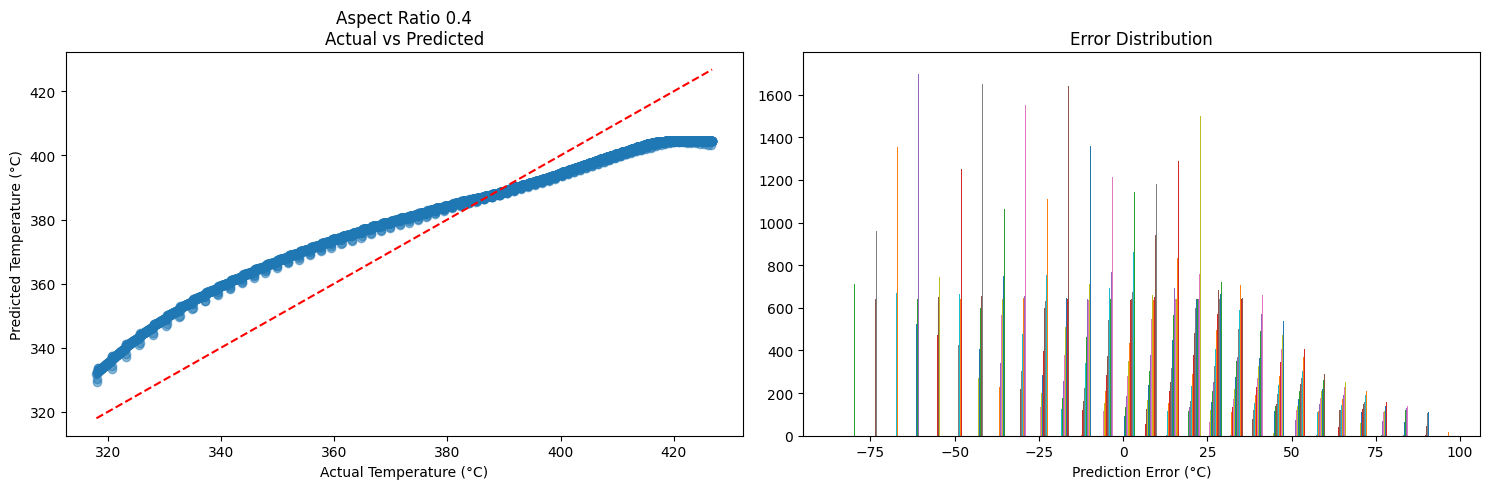


Evaluating Aspect Ratio 0.5


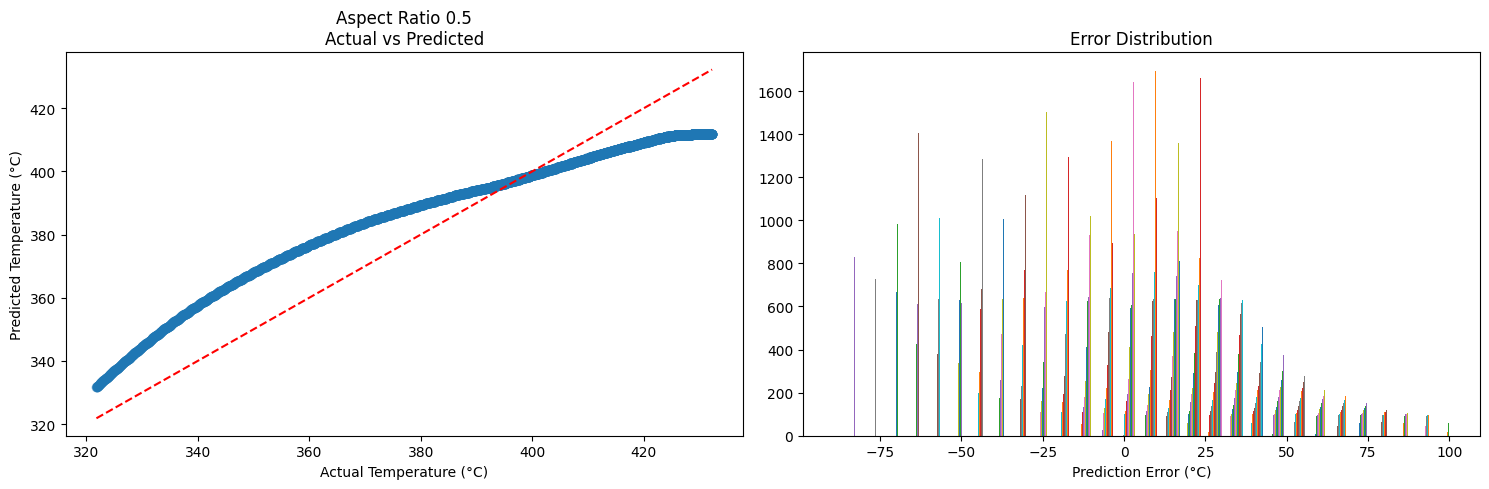


Comparative Performance Across Aspect Ratios:
Ratio    MAE(°C)    RMSE(°C)   R²       Max Error   
0.4      11.36      12.90      0.83     97.39       
0.5      10.89      12.28      0.85     100.57      


In [10]:
results = {}
for ratio, dataset in datasets.items():
    if dataset is None:
        continue

    X_train, X_test, y_train, y_test, stats = dataset
    print(f"\n\033[1mEvaluating Aspect Ratio {ratio}\033[0m")

    try:
        results[ratio] = evaluate_model(model, X_test, y_test, stats, ratio)
    except Exception as e:
        print(f"\033[91mEvaluation failed for {ratio}: {str(e)}\033[0m")
        continue

# Display results
if not results:
    print("\n\033[91mNo valid results to display\033[0m")
else:
    print("\n\033[1mComparative Performance Across Aspect Ratios:\033[0m")
    print("{:<8} {:<10} {:<10} {:<8} {:<12}".format(
        "Ratio", "MAE(°C)", "RMSE(°C)", "R²", "Max Error"))

    for ratio, metrics in results.items():
        print("{:<8} {:<10.2f} {:<10.2f} {:<8.2f} {:<12.2f}".format(
            ratio,
            metrics['mae'],
            metrics['rmse'],
            metrics['r2'],
            metrics['max_error']))

In [11]:
def error_analysis(model, X_test, y_test, norm_stats):
    """
    Robust error analysis with shape handling
    """
    # Ensure model is in eval mode
    model.eval()

    # Convert to tensors and predict
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_pred = model(X_test_tensor).numpy()

    # Denormalize
    y_mean, y_std = norm_stats[2], norm_stats[3]
    y_test_actual = (y_test * y_std + y_mean).flatten()  # Ensure 1D array
    y_pred_actual = (y_pred * y_std + y_mean).flatten()

    # Calculate errors
    errors = y_test_actual - y_pred_actual

    # 1. Create figure
    plt.figure(figsize=(15,5))

    # 2. Scatter plot (with shape validation)
    plt.subplot(1,2,1)
    plt.scatter(y_test_actual, errors, alpha=0.5,
               label=f'MAE: {np.mean(np.abs(errors)):.2f}°C')
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('True Temperature (°C)')
    plt.ylabel('Prediction Error (°C)')
    plt.title('Error vs True Temperature')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Error histogram
    plt.subplot(1,2,2)
    plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(np.mean(errors), color='r', linestyle='--',
               label=f'Mean: {np.mean(errors):.2f}°C')
    plt.xlabel('Prediction Error (°C)')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 4. Worst-case analysis
    worst_idx = np.argsort(np.abs(errors))[-5:]
    print("\nWorst Predictions Analysis:")
    print("-"*40)
    print(f"{'Index':<10}{'True (°C)':<12}{'Predicted (°C)':<15}{'Error (°C)':<10}")
    for idx in worst_idx:
        print(f"{idx:<10}{y_test_actual[idx]:<12.2f}{y_pred_actual[idx]:<15.2f}{errors[idx]:<10.2f}")

    return {
        'y_test': y_test_actual,
        'y_pred': y_pred_actual,
        'errors': errors,
        'mae': np.mean(np.abs(errors)),
        'worst_indices': worst_idx
    }

Error Analysis :


Error Analysis for Aspect Ratio 0.4
Shapes - X_test: (5490, 10, 4), y_test: (5490,)


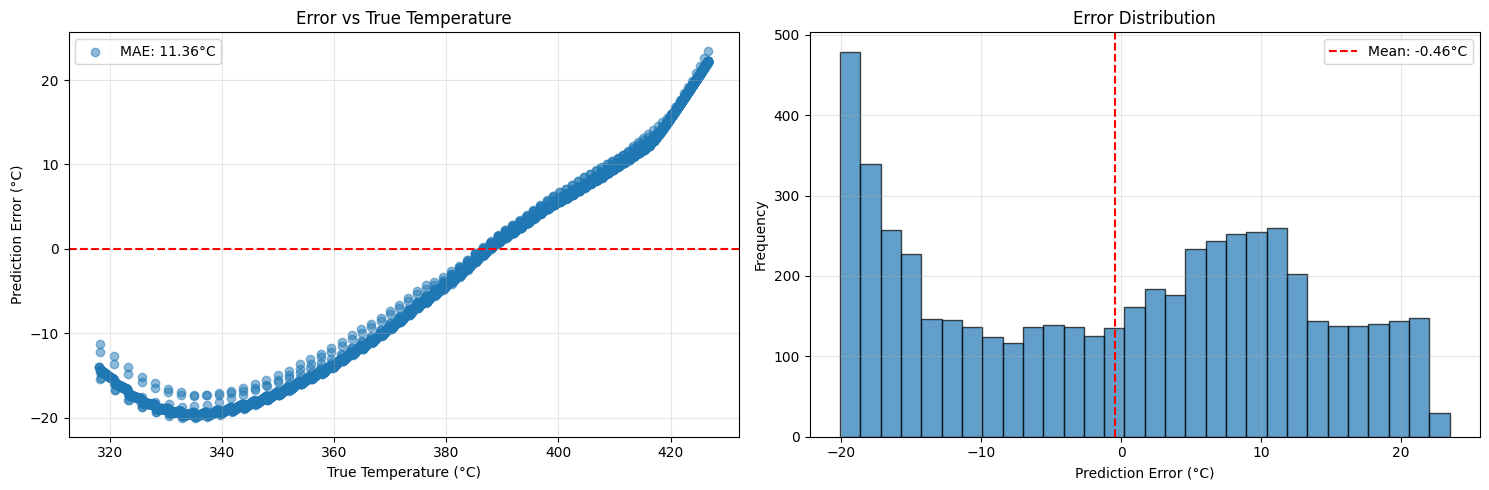


Worst Predictions Analysis:
----------------------------------------
Index     True (°C)   Predicted (°C) Error (°C)
5489      426.77      404.48         22.30     
5488      426.76      404.46         22.31     
5479      426.68      404.37         22.31     
5405      425.97      403.39         22.59     
5476      426.65      403.18         23.47     

Features for worst predictions:
[[[-1.77854565e-05 -8.88178341e-08 -1.72233139e+00  1.37482454e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.73206178e+00  1.37520796e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.73129106e+00  1.37562099e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.72108179e+00  1.37591333e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.73495037e+00  1.37622175e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.72855621e+00  1.37643410e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.72782781e+00  1.37667124e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.72907756e+00  1.37702094e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.72832150e+00  1.37743704e+0

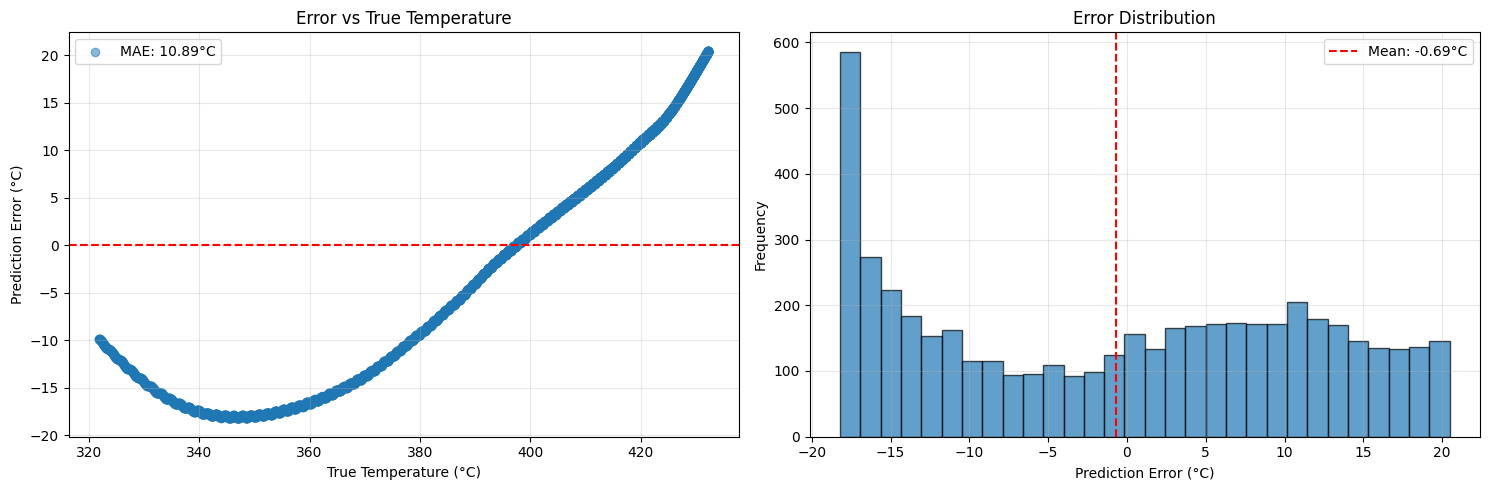


Worst Predictions Analysis:
----------------------------------------
Index     True (°C)   Predicted (°C) Error (°C)
4985      432.20      411.76         20.44     
4986      432.21      411.77         20.44     
4987      432.22      411.77         20.45     
4988      432.23      411.77         20.46     
4989      432.24      411.77         20.47     

Features for worst predictions:
[[[ 0.          0.         -1.29809191  1.30985706]
  [ 0.          0.         -1.29973983  1.31014602]
  [ 0.          0.         -1.30109282  1.310434  ]
  [ 0.          0.         -1.30154618  1.31072174]
  [ 0.          0.         -1.30348999  1.31100835]
  [ 0.          0.         -1.30661298  1.31129292]
  [ 0.          0.         -1.30897193  1.31157592]
  [ 0.          0.         -1.31111237  1.31185798]
  [ 0.          0.         -1.31177774  1.31213981]
  [ 0.          0.         -1.31376861  1.31242065]]

 [[ 0.          0.         -1.29973983  1.31014602]
  [ 0.          0.         -1.30109

In [12]:
# After model evaluation
for ratio, dataset in datasets.items():
    if dataset is not None:
        X_train, X_test, y_train, y_test, stats = dataset
        print(f"\n\033[1mError Analysis for Aspect Ratio {ratio}\033[0m")

        # Shape debugging (optional)
        print(f"Shapes - X_test: {X_test.shape}, y_test: {y_test.shape}")

        error_results = error_analysis(model, X_test, y_test, stats)

        # Optional: Examine worst cases
        worst_features = X_test[error_results['worst_indices']]
        print("\nFeatures for worst predictions:")
        print(worst_features)

In [13]:
# Replace the non-working cell with this corrected version:

# Get denormalized test predictions first
with torch.no_grad():
    y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

# Denormalize
y_mean, y_std = norm_stats[2], norm_stats[3]
y_test_actual = (y_test * y_std + y_mean).flatten()
y_pred_actual = (y_pred * y_std + y_mean).flatten()

# Define critical temperature thresholds (using C5 battery max of 70°C)
critical_threshold = 70  # Maximum operating temperature
warning_threshold = 65   # Warning level (5°C below max)
safety_margin = 5        # Degrees below max for safety buffer

# Convert to binary classes
Y_test_class = (y_test_actual > critical_threshold).astype(int)
Y_pred_class = (y_pred_actual > critical_threshold).astype(int)

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def calculate_classification_metrics(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Overheat'],
                yticklabels=['Normal', 'Overheat'])
    plt.title('Confusion Matrix')
    plt.show()

    return metrics

In [18]:
def evaluate_classification(model, X_test, y_test, norm_stats, threshold):
    # Get predictions
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

    # Denormalize
    y_mean, y_std = norm_stats[2], norm_stats[3]
    y_test_actual = (y_test * y_std + y_mean).flatten()
    y_pred_actual = (y_pred * y_std + y_mean).flatten()

    # Convert to classes
    y_test_class = (y_test_actual > threshold).astype(int)
    y_pred_class = (y_pred_actual > threshold).astype(int)

    # Only calculate if both classes exist
    if len(np.unique(y_test_class)) > 1:
        return calculate_classification_metrics(y_test_class, y_pred_class)
    else:
        print(f"Warning: Only one class present at threshold {threshold}°C")
        return None

# Example usage
critical_metrics = evaluate_classification(model, X_test, y_test, norm_stats, critical_threshold)
warning_metrics = evaluate_classification(model, X_test, y_test, norm_stats, warning_threshold)

if critical_metrics:
    print("\nCritical Threshold Metrics:")
    print(f"Accuracy: {critical_metrics['accuracy']:.2f}")
    print(f"Precision: {critical_metrics['precision']:.2f}")
    print(f"Recall: {critical_metrics['recall']:.2f}")
    print(f"F1 Score: {critical_metrics['f1']:.2f}")

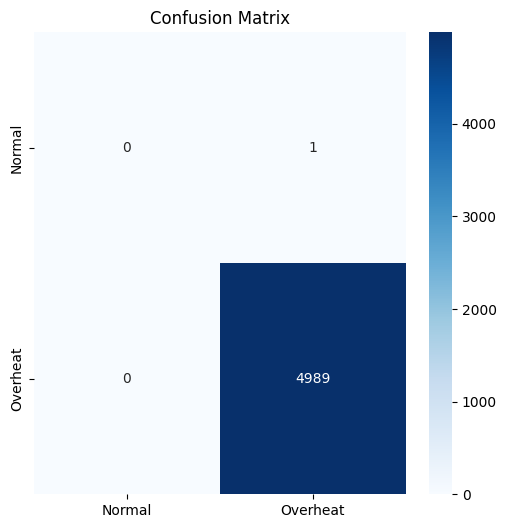

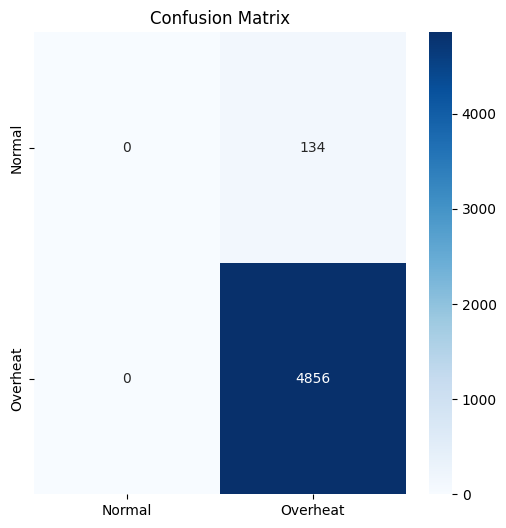

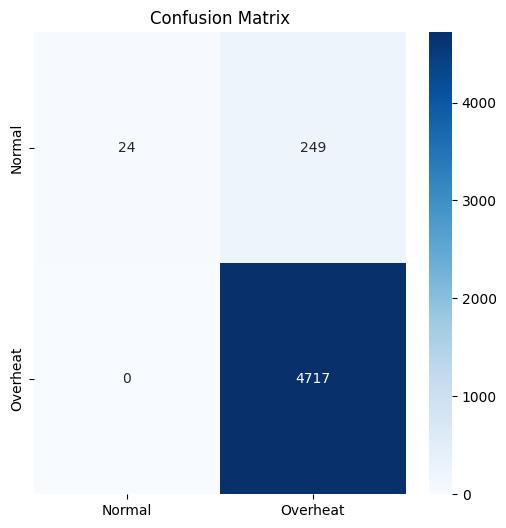

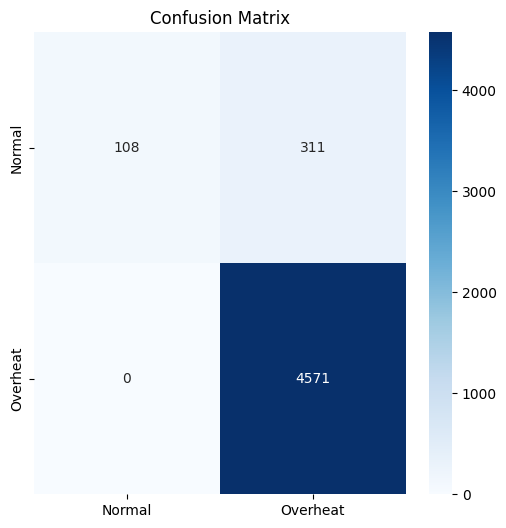

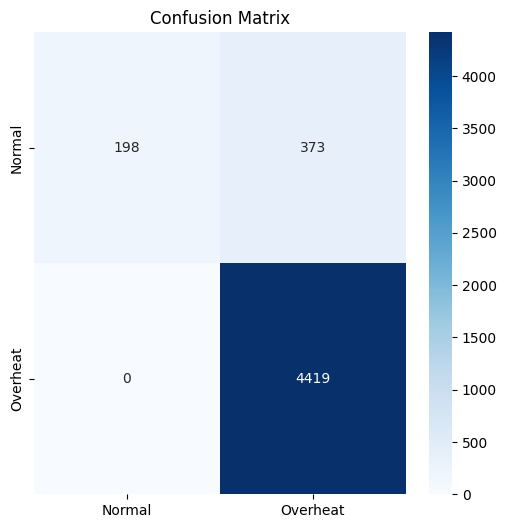

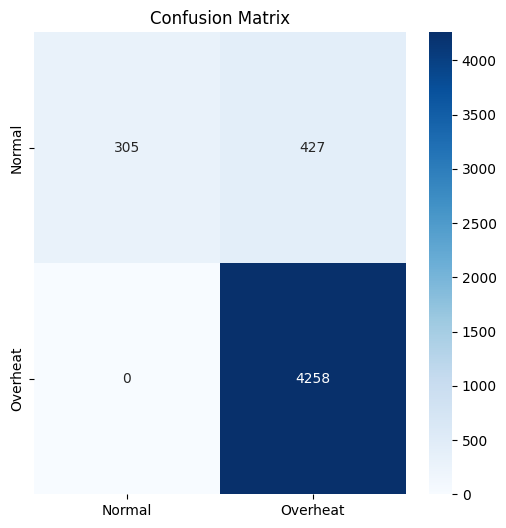

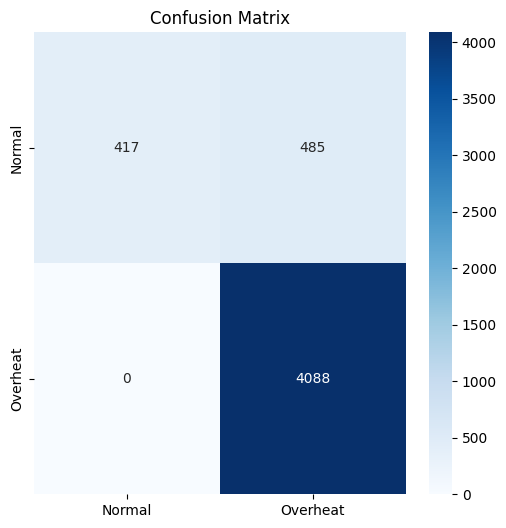

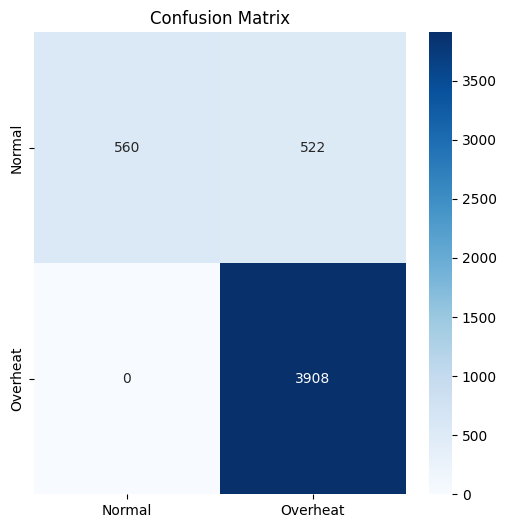

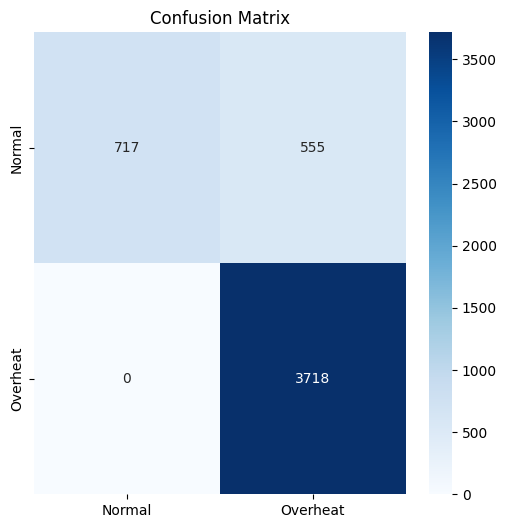

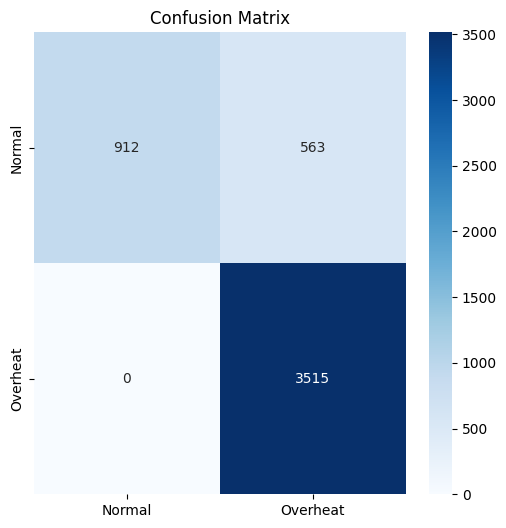

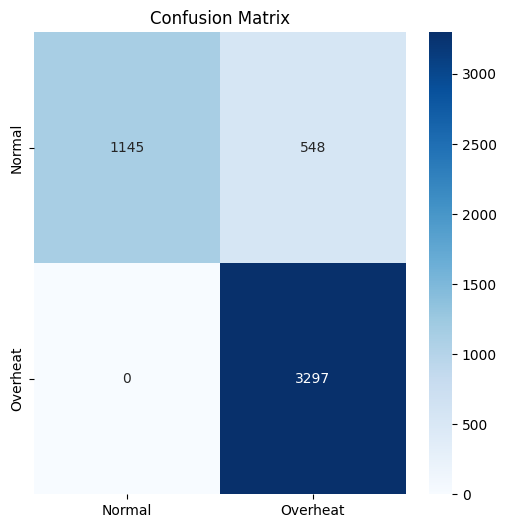

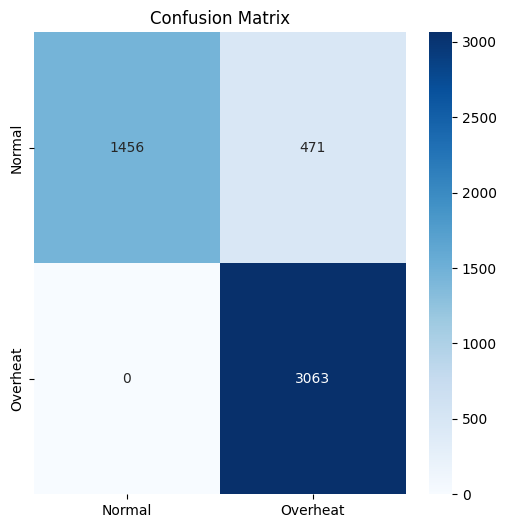

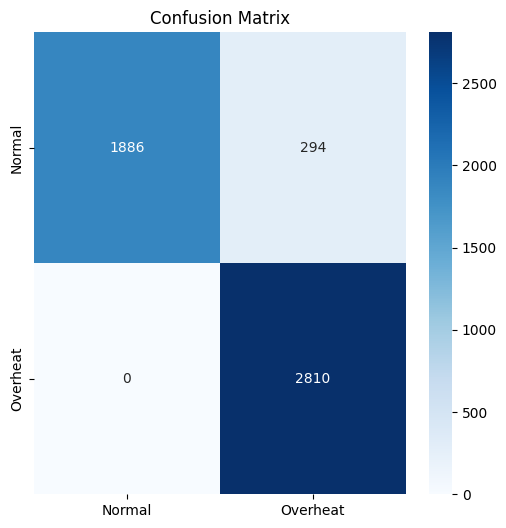

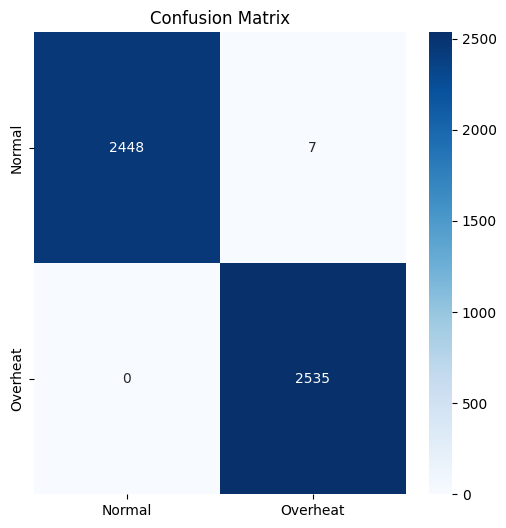

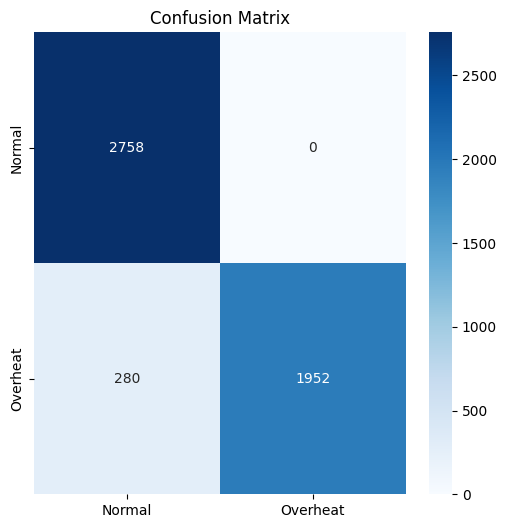

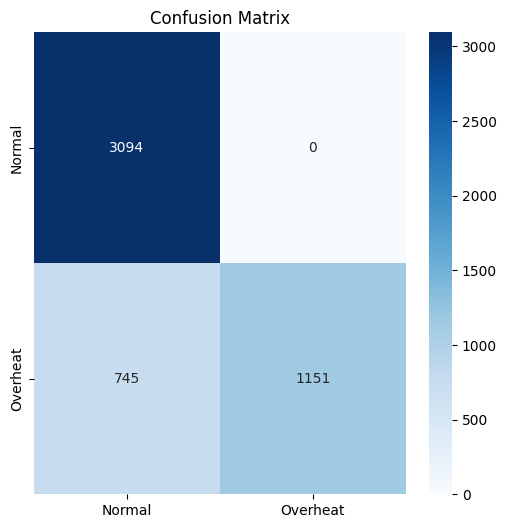

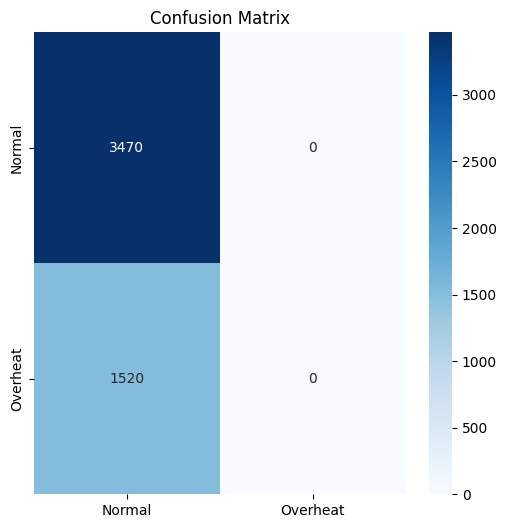

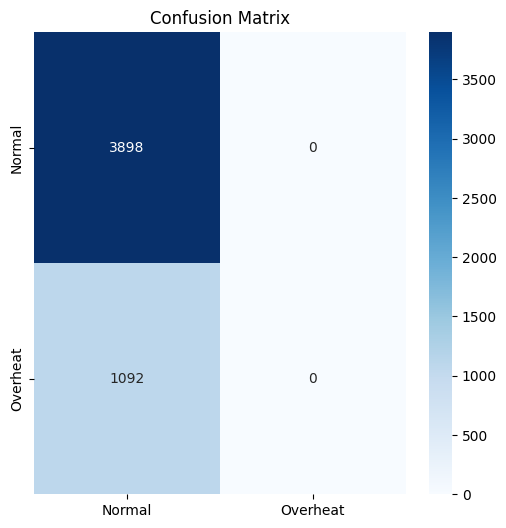

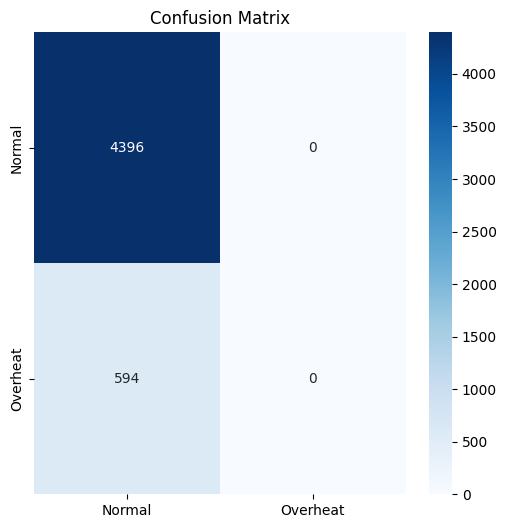

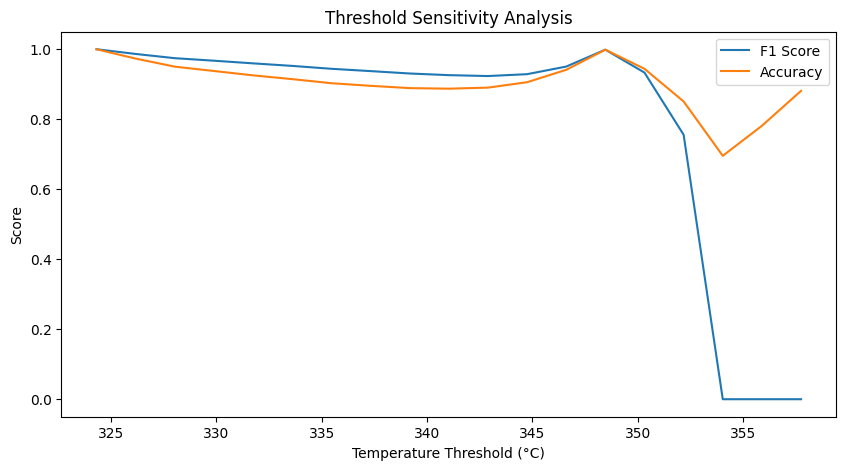

In [17]:
import seaborn as sns
thresholds = np.linspace(y_test_actual.min(), y_test_actual.max(), 20)
results = []

for thresh in thresholds:
    metrics = evaluate_classification(model, X_test, y_test, norm_stats, thresh)
    if metrics:
        results.append({
            'threshold': thresh,
            **metrics
        })

# Plot results
if results:
    results_df = pd.DataFrame(results)
    plt.figure(figsize=(10,5))
    plt.plot(results_df['threshold'], results_df['f1'], label='F1 Score')
    plt.plot(results_df['threshold'], results_df['accuracy'], label='Accuracy')
    plt.xlabel('Temperature Threshold (°C)')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Threshold Sensitivity Analysis')
    plt.show()